# MultiLayer Multiclass Classification

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST,EMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


/home/bikasherl/miniconda3/envs/bajra/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# EMNIST Dataset

In [2]:
train_edata=EMNIST(root='emnist_dataset/train/',split='balanced',train=True,download=True,transform=ToTensor())
test_edata=EMNIST(root='emnist_dataset/test/',split='balanced',train=False,download=True,transform=ToTensor())
train_edata,test_edata

(Dataset EMNIST
     Number of datapoints: 112800
     Root location: emnist_dataset/train/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset EMNIST
     Number of datapoints: 18800
     Root location: emnist_dataset/test/
     Split: Test
     StandardTransform
 Transform: ToTensor())

## Lets See How the Dataset Looks Like

80


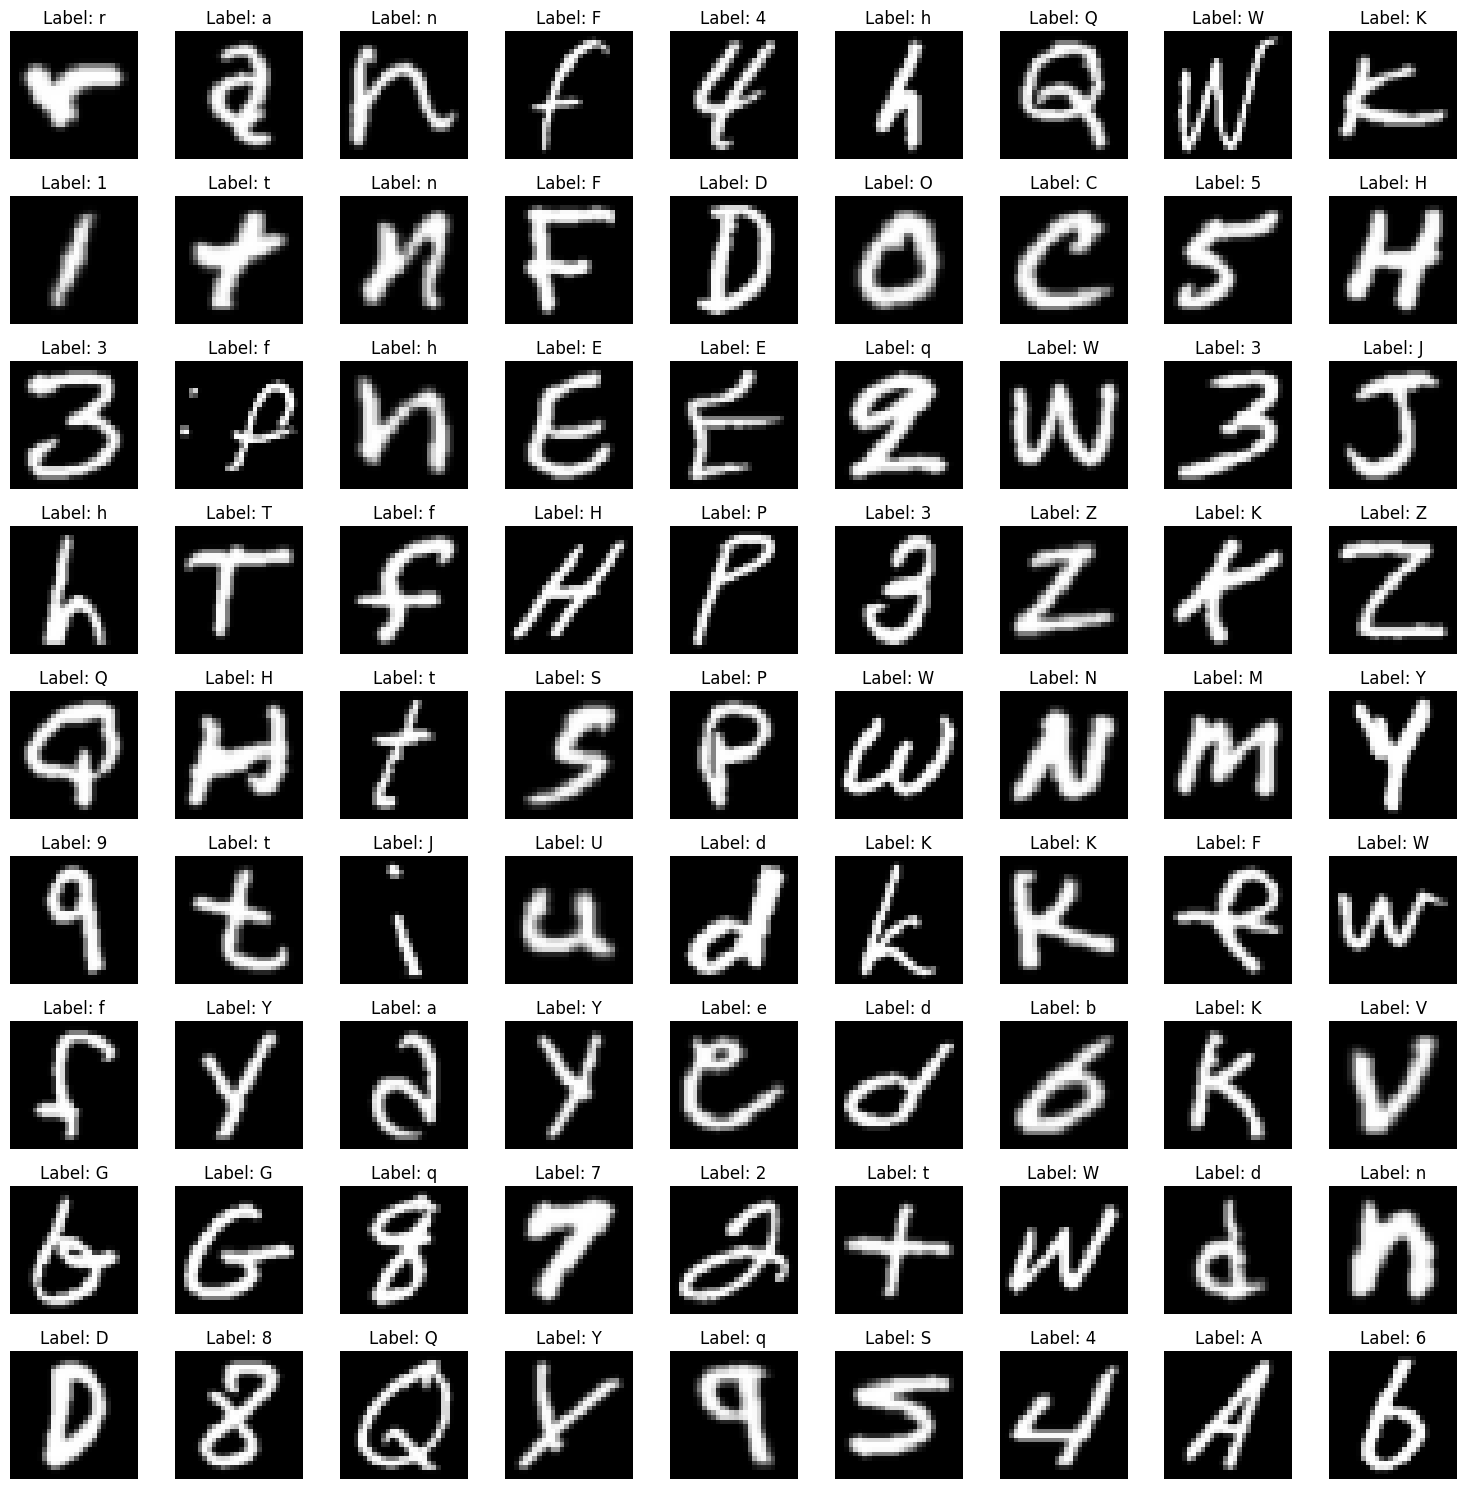

In [3]:
# Create subplots
fig, axs = plt.subplots(9, 9, figsize=(15, 15))

# Plot images
# Plot images
c=-1
j=0
i=-1

end_loop=False

while i!=9:
    if end_loop:
        print(c)
        break
    i+=1
    j=0
    while j!=9:
        c+=1
        img, label = train_edata[c]  # Accessing each image and label
        if list((train_edata.class_to_idx).keys())[label]:  #=='q':   can filter specific character
            axs[i, j].imshow(img.squeeze().T,cmap='gray')
            axs[i, j].set_title(f'Label: {list((train_edata.class_to_idx).keys())[label]}')
            axs[i, j].axis('off')  # Hide axis
            j+=1
        if((c==2000) or (i==8 and j>8)):  # could scan maximum of 2k images and minimum of 81 elements
            end_loop=True
            break        


plt.tight_layout()
plt.show()


## Train and Test Set Preparation

In [4]:
#train set
X_etrain=torch.flatten(train_edata.data,1,2).to(torch.float32)
Y_etrain=train_edata.targets.reshape(X_etrain.shape[0],1).to(torch.int8)

# test set
X_etest=torch.flatten(test_edata.data,1,2).to(torch.float32)
Y_etest=test_edata.targets.reshape(X_etest.shape[0],1).to(torch.int8)

X_etrain.shape,Y_etrain.shape,X_etest.shape,Y_etest.shape

(torch.Size([112800, 784]),
 torch.Size([112800, 1]),
 torch.Size([18800, 784]),
 torch.Size([18800, 1]))

## Min max Scaling of Train and Test Data

In [5]:
# scaling train dataset
for i in range(X_etrain.shape[0]):
    X_etrain[i]=(X_etrain[i]-X_etrain[i].min())/(X_etrain[i].max()-X_etrain[i].min())


# scaling test dataset
for i in range(X_etest.shape[0]):
    X_etest[i]=(X_etest[i]-X_etest[i].min())/(X_etest[i].max()-X_etest[i].min())

## One hot encoding for the labels

In [6]:
## One hot encoding For the labels

Y_enc_etrain=torch.zeros((Y_etrain.shape[0],len(train_edata.classes))).to(torch.int8)

for i in range(Y_etrain.shape[0]):
    Y_enc_etrain[i][Y_etrain[i].item()]=1


Y_enc_etest=torch.zeros((Y_etest.shape[0],len(test_edata.classes))).to(torch.int8)

for i in range(Y_etest.shape[0]):
    Y_enc_etest[i][Y_etest[i].item()]=1


Y_enc_etrain.shape,Y_enc_etest.shape

(torch.Size([112800, 47]), torch.Size([18800, 47]))

In [7]:
X_jacob=X_etrain[:1000,:]
Y_jacob=Y_enc_etrain[:1000,:]

## Weights and Bias Initialization

In [8]:

num_input=X_etrain.shape[1]
num_hidden=128


# kaiming weight initialization
W1=torch.randn((num_input,num_hidden),dtype=torch.float32,requires_grad=True)*torch.sqrt(torch.tensor(2/num_input))
b1=torch.randn((1,num_hidden),dtype=torch.float32,requires_grad=True)*torch.sqrt(torch.tensor(2/num_input))

W2=torch.randn((num_hidden,Y_enc_etrain.shape[1]),dtype=torch.float32,requires_grad=True)*torch.sqrt(torch.tensor(2/num_hidden))
b2=torch.randn((1,Y_enc_etrain.shape[1]),dtype=torch.float32,requires_grad=True)*torch.sqrt(torch.tensor(2/num_hidden))


print(f"shape- W1: {W1.shape}\
       \nshape- b1: {b1.shape}\
      \nshape- W2: {W2.shape}\
      \nshape- b2: {b2.shape}")

shape- W1: torch.Size([784, 128])       
shape- b1: torch.Size([1, 128])      
shape- W2: torch.Size([128, 47])      
shape- b2: torch.Size([1, 47])


## Utility Functions

In [9]:
def softmax(Z):
    return (torch.exp(Z)/torch.sum(torch.exp(Z),dim=1,keepdim=True))

def categorical_cross_entropy(Y_enc_train,Y_hat):
    return torch.sum((-Y_enc_train*torch.log(Y_hat)),dim=1,keepdim=True).mean()

#check manually calculated gradients with that of pytorch autograd
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

## Deriving Jacobian Matrix

In [10]:
def derive_jacob(Y_hat):
    I=torch.eye(Y_hat.shape[1])
    jacob=(((1-I)*Y_hat.unsqueeze(2))*((I-1)*torch.transpose(Y_hat.unsqueeze(2),1,2)))+(((I)*Y_hat.unsqueeze(2))*(I*(1-(Y_hat.unsqueeze(2)))))
    return jacob

def get_dL_dZ(jacob,dL_da):
    return jacob@dL_da

## Validating Manually Computed Gradient with `torch.autograd`

In [11]:
Z1=X_jacob@W1 + b1
A1=torch.relu(Z1)

Z2=A1@W2 + b2
Y_ehat=softmax(Z2)

Loss=categorical_cross_entropy(Y_jacob,Y_ehat)


# backpropgation
# dL_dZ2=(Y_ehat-Y_enc_etrain)/X_etrain.shape[0]

dL_dY_ehat=((-Y_jacob/Y_ehat)/Y_jacob.shape[0]).unsqueeze(dim=2)
jacob=derive_jacob(Y_ehat)
dL_dZ2=get_dL_dZ(jacob,dL_dY_ehat)

dZ2_dW2=A1

dL_dW2=dZ2_dW2.T@dL_dZ2.squeeze(2)
dL_db2=torch.sum(dL_dZ2.squeeze(2),dim=0,keepdim=True)


dZ2_dA1=W2
dL_dA1= dL_dZ2.squeeze(2) @ dZ2_dA1.T


dA1_dZ1=torch.where((Z1<0),0, 1)

dL_dZ1=(dA1_dZ1 * dL_dA1)

dZ1_dW1=X_jacob

dL_dW1=dZ1_dW1.T @ dL_dZ1
dL_db1=torch.sum(dL_dZ1,dim=0,keepdim=True)

for each in [W1,W2,b1,b2,A1,Z1,Z2]:
    each.retain_grad()

In [12]:
Loss.backward()

In [13]:
cmp("dZ2", dL_dZ2.squeeze(2), Z2)
cmp("dW2", dL_dW2, W2)
cmp("db2", dL_db2, b2)
cmp("dA1", dL_dA1, A1)
cmp("dZ1", dL_dZ1, Z1)
cmp("dW1", dL_dW1, W1)
cmp("db1", dL_db1, b1)

dZ2             | exact: False | approximate: True  | maxdiff: 2.9103830456733704e-10
dW2             | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
db2             | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
dA1             | exact: False | approximate: True  | maxdiff: 1.1641532182693481e-10
dZ1             | exact: False | approximate: True  | maxdiff: 1.1641532182693481e-10
dW1             | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
db1             | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


## Building and Training the Model

In [ ]:
loss_list_train=[]
loss_list_test=[]

In [ ]:

for epoch in range(1000):

    # forward pass
    Z1=X_etrain@W1 + b1
    A1=torch.relu(Z1)

    Z2=A1@W2 + b2
    Y_ehat=softmax(Z2)
    
    Loss=categorical_cross_entropy(Y_enc_etrain,Y_ehat)
    # Loss=torch.sum((-Y_enc_etrain*torch.log(Y_ehat)),dim=1,keepdim=True).mean()

    loss_list_train.append(Loss.item())

    # backpropgation
    dL_dZ2=(Y_ehat-Y_enc_etrain)/X_etrain.shape[0]
    dZ2_dW2=A1
    
    dL_dW2=dZ2_dW2.T@dL_dZ2
    dL_db2=torch.sum(dL_dZ2,dim=0,keepdim=True)


    dZ2_dA1=W2
    dL_dA1= dL_dZ2 @ dZ2_dA1.T


    dA1_dZ1=torch.where((Z1<0),0, 1)

    dL_dZ1=(dA1_dZ1 * dL_dA1)

    dZ1_dW1=X_etrain

    dL_dW1=dZ1_dW1.T @ dL_dZ1
    dL_db1=torch.sum(dL_dZ1,dim=0,keepdim=True)

    with torch.no_grad():
        # weights and biases optimization
        W2-=0.9*dL_dW2
        b2-=0.9*dL_db2
        W1-=0.9*dL_dW1
        b1-=0.9*dL_db1

    # validating in the test set
    Z1_test=X_etest@W1+b1
    A1=torch.relu(Z1_test)
    Z2_test=A1@W2 + b2
    Y_hat_test=softmax(Z2_test)
    Loss_test=torch.sum((-Y_enc_etest*torch.log(Y_hat_test)),dim=1,keepdim=True).mean()
    loss_list_test.append(Loss_test.item())

    
    if epoch % 100==0:
        print(f" Epoch: {epoch} | Train Loss: {Loss.item()} | Test Loss: {Loss_test.item()}")



 Epoch: 0 | Train Loss: 3.966513156890869 | Test Loss: 3.7336137294769287
 Epoch: 100 | Train Loss: 1.104152798652649 | Test Loss: 1.1395535469055176
 Epoch: 200 | Train Loss: 0.8738710880279541 | Test Loss: 0.9106670618057251
 Epoch: 300 | Train Loss: 0.7455810308456421 | Test Loss: 0.8012396097183228
 Epoch: 400 | Train Loss: 0.6736546754837036 | Test Loss: 0.7296730279922485
 Epoch: 500 | Train Loss: 0.6274734139442444 | Test Loss: 0.6958301663398743
 Epoch: 600 | Train Loss: 0.5885012745857239 | Test Loss: 0.6562815308570862
 Epoch: 700 | Train Loss: 0.5584405660629272 | Test Loss: 0.6299887299537659
 Epoch: 800 | Train Loss: 0.5366469025611877 | Test Loss: 0.6136348247528076
 Epoch: 900 | Train Loss: 0.5157080888748169 | Test Loss: 0.5983699560165405


## Saving the Model

In [ ]:
parameters={
    "W1":W1,
    "W2":W2,
    "b1":b1,
    "b2":b2
}
torch.save(parameters,'MLP_model.pt')

## Loss Curves

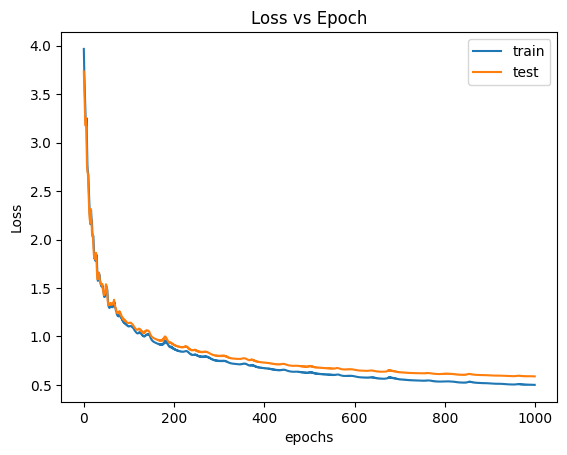

In [ ]:
plt.plot(loss_list_train,label='train')
plt.plot(loss_list_test,label='test')
plt.title("Loss vs Epoch")
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Load the Model

In [11]:
params=torch.load('MLP_model.pt')
params.keys()

dict_keys(['W1', 'W2', 'b1', 'b2'])

## Train and Test Accuracy

In [12]:
# train accuracy
Z1_etrain=X_etrain@params['W1']+params['b1']
A1_train=torch.relu(Z1_etrain)
Z2_etrain=A1_train@params['W2'] + params['b2']
Y_hat_etrain=softmax(Z2_etrain)
y_pred_etrain=torch.argmax(Y_hat_etrain,dim=1,keepdim=True)

train_acc=torch.sum(Y_etrain==y_pred_etrain)/Y_etrain.shape[0]


# test accuracy
Z1_etest=X_etest@params['W1']+params['b1']
A1=torch.relu(Z1_etest)
Z2_etest=A1@params['W2'] + params['b2']
Y_hat_etest=softmax(Z2_etest)
y_pred_etest=torch.argmax(Y_hat_etest,dim=1,keepdim=True)

test_acc=torch.sum(Y_etest==y_pred_etest)/Y_etest.shape[0]

print(f"Train Accuracy: {train_acc*100: .2f}%\
      \nTest Accuracy: {test_acc*100: .2f}%")

Train Accuracy:  83.61%      
Test Accuracy:  81.19%


In [13]:
num_classes=Y_hat_etrain.shape[1]
exp=Y_hat_etrain.unsqueeze(2)
print((Y_hat_etrain.unsqueeze(2)).shape)
I=torch.eye(num_classes)
1-I


torch.Size([112800, 47, 1])


tensor([[0., 1., 1.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 0., 1., 1.],
        [1., 1., 1.,  ..., 1., 0., 1.],
        [1., 1., 1.,  ..., 1., 1., 0.]])

In [ ]:
exp[0,:3]

tensor([[1.2736e-06],
        [3.8130e-07],
        [5.0141e-07]], grad_fn=<SliceBackward0>)

In [ ]:
((1-I)*Y_hat_etrain.unsqueeze(2)).shape

torch.Size([112800, 47, 47])

In [ ]:
((I-1)*Y_hat_etrain.unsqueeze(1)).shape

torch.Size([112800, 47, 47])

In [20]:
f_elem=((1-I)*Y_hat_etrain.unsqueeze(2)[:10,:,:])*((I-1)*Y_hat_etrain.unsqueeze(1)[:10,:,:])

In [21]:
s_elem=((I)*Y_hat_etrain.unsqueeze(2)[:10,:,:])*(I*(1-(Y_hat_etrain.unsqueeze(2)[:10,:,:])))

In [15]:
jacob=(((1-I)*Y_hat_etrain.unsqueeze(2))*((I-1)*Y_hat_etrain.unsqueeze(2)))+(((I)*Y_hat_etrain.unsqueeze(2))*(I*(1-(Y_hat_etrain.unsqueeze(2)))))
jacob.shape

torch.Size([112800, 47, 47])

## Lets see what we got wrong prediction on

63


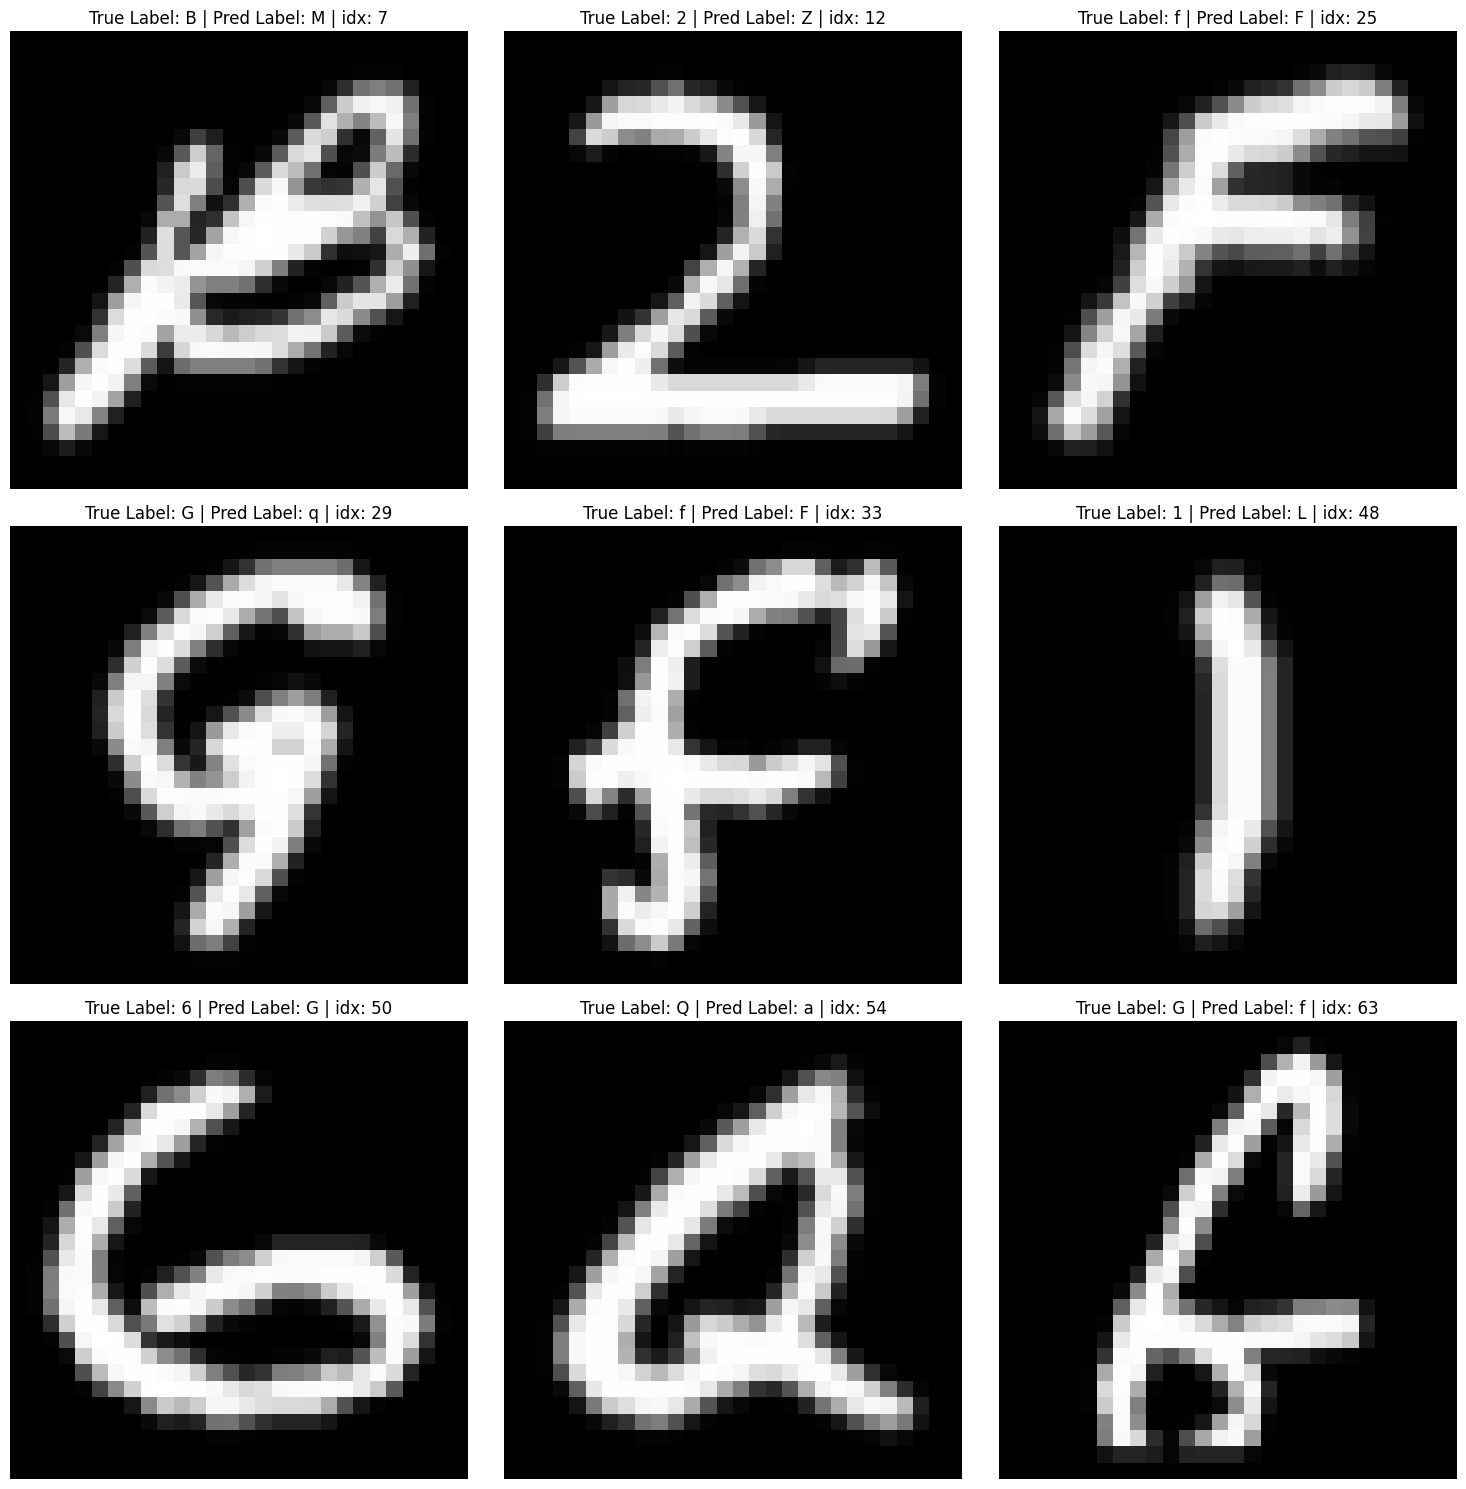

In [ ]:
# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Plot images
# Plot images
c=-1
j=0
i=-1

end_loop=False

while i!=3:
    if end_loop:
        print(c)
        break
    i+=1
    j=0
    while j!=3:
        c+=1
        img, label = test_edata[c]  # Accessing each image and label
        if (label!=y_pred_etest[c].item()):
            axs[i, j].imshow(img.squeeze().T,cmap='gray')
            axs[i, j].set_title(f'True Label: {list((train_edata.class_to_idx).keys())[label]} | Pred Label: {list((train_edata.class_to_idx).keys())[y_pred_etest[c].item()]} | idx: {c}')
            axs[i, j].axis('off')  # Hide axis
            j+=1
        if((c==40000) or (i==2 and j>2)):  # could scan maximum of 2k images and minimum of 81 elements
            end_loop=True
            break        


plt.tight_layout()
plt.show()

## Inferencing on Custom Image

Text(0.5, 1.0, 'Original Image')

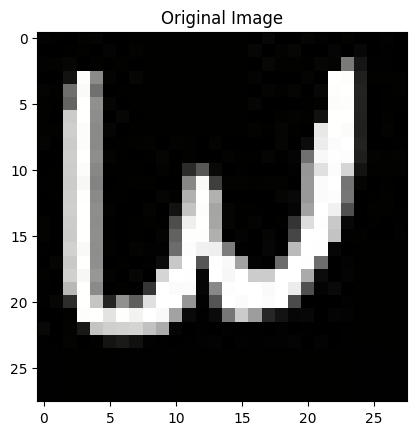

In [ ]:
inf_img=torch.tensor(plt.imread('image4.jpeg'))
plt.imshow(inf_img)
plt.title("Original Image")

torch.Size([1, 784])


Text(0.5, 1.0, 'Transposing Image to make it similar to training samples')

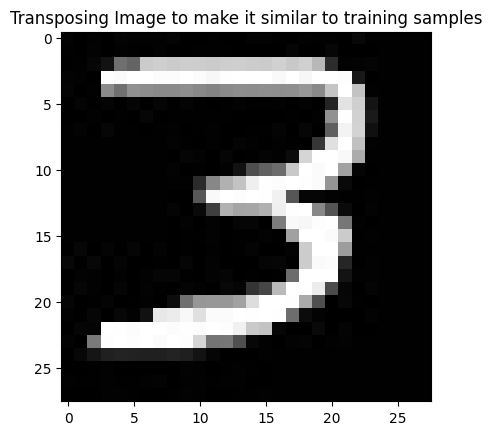

In [ ]:

inf_img=inf_img[:,:,0].T

# flatten the image
inf_img=inf_img.flatten(0,1).reshape(1,-1)
print(inf_img.shape)
# scaling the image
inf_img=(inf_img-inf_img.min())/(inf_img.max()-inf_img.min())
plt.imshow(inf_img.view(28,28),cmap='gray')
plt.title("Transposing Image to make it similar to training samples")

In [ ]:
# Prediction
Z1_inf=inf_img@params['W1']+params['b1']
A1=torch.relu(Z1_inf)
Z2_inf=A1@params['W2'] + params['b2']

Y_hat_inf=softmax(Z2_inf)
y_pred_inf=torch.argmax(Y_hat_inf,dim=1,keepdim=True)

print(f"The predicted character is: {list((train_edata.class_to_idx).keys())[y_pred_inf.item()]}")

The predicted character is: W
